In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import json

https://www.kaggle.com/maksimeren/covid-19-literature-clustering#Load-the-Data

# Import

Import Metadata

In [6]:
meta_df = pd.read_csv("metadata.csv",
                          dtype={
                             "pubmed_id": str,
                              "Microsoft Academic Paper ID": str
                          }
                         )
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44220 entries, 0 to 44219
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   sha                          28462 non-null  object
 1   source_x                     44220 non-null  object
 2   title                        43996 non-null  object
 3   doi                          40750 non-null  object
 4   pmcid                        23319 non-null  object
 5   pubmed_id                    22943 non-null  object
 6   license                      44220 non-null  object
 7   abstract                     35806 non-null  object
 8   publish_time                 34197 non-null  object
 9   authors                      41074 non-null  object
 10  journal                      33173 non-null  object
 11  Microsoft Academic Paper ID  964 non-null    object
 12  WHO #Covidence               1767 non-null   object
 13  has_full_text                44

Get json paths

In [7]:
all_json = glob.glob(f'**/*.json', recursive=True)

In [8]:
def get_breaks(content, length=40):
    ''' 
    Make long summaries readable in the plot tooltip.
    Adds break after every word when line reaches a certain character amount, by default 40
    '''
    data = ""
    words = content.split(' ')
    total_chars = 0

    # add break every length characters
    for i in range(len(words)):
        total_chars += len(words[i]) # get length of each word
        if total_chars > length:
            # add 'enter' after each word if the total length up to that point is > length variable
            data = data + "<br>" + words[i] 
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data

In [9]:
class FileReader:
    '''
    Extracts information from provided JSON file paths.
    
    Callable functions:
        * summarize_abstract(): returns the abstract with < 100 words, 40 characters per line
        * summarize_authors(): returns a max of 2 authors, with rest of authors denoted with "et al."
        * summarize_title(): returns the title with 40 characters per line
    
    Returns:
        * a print out of the paper id, abstract (200 characters), and body (200 characters)
    '''
    def __init__(self, file_path):
        '''
        Open the file. Extract the paper id, abstract, and body. Match it with the metadata.
        
        Callable variables:
            * content: the full, raw content of the json path
            * paper_id: the paper id stored in the json file
            * meta_data: the metadata that has a paper id match in the meta_df
            * journal: the journal paper was published in
            * abstract: the full abstract
            * body_text: the full body
        '''
        with open(file_path) as file:
            content = json.load(file)
            self.content = content
            self.paper_id = content['paper_id']
            self.meta_data = meta_df[meta_df['sha'] == self.paper_id]
            self.abstract = []
            self.body_text = []

            if len(self.meta_data) != 0:
                self.journal = self.meta_data['journal'].values[0]

                # Abstract
                for entry in content['abstract']:
                    self.abstract.append(entry['text'])
                self.abstract = '\n'.join(self.abstract)

                # Body text
                for entry in content['body_text']:
                    self.body_text.append(entry['text'])          
                self.body_text = '\n'.join(self.body_text)         


    def summarize_abstract(self):
        '''
        Limits abstract summary to <= 40 words for the plot tool tip.
        '''
        if len(self.abstract) == 0:
            abstract_summary = ("Not provided.")
            return abstract_summary
        elif len(self.abstract) > 100:
            # abstract is too long, take first 100 words and run through function
            info = self.abstract.split(' ')[:100]
            abstract_summary = get_breaks(' '.join(info)) + " ..."
            return abstract_summary
        else:
            # abstract is short enough, just run through function
            abstract_summary = get_breaks(self.abstract)
            return abstract_summary
            
    def summarize_authors(self):
        '''
        Limit number of authors to <= 2 for the plot tool tip
        '''
        try:
            # More than one author
            authors = self.meta_data['authors'].values[0].split(';')
            if len(authors) > 2:
                authors = ". ".join(authors[:2]) + ", et al."
                return authors
            else:
                authors = ". ".join(authors)
                return authors
        except Exception as e:
            # Just one author or no author
            authors = self.meta_data['authors'].values[0]
            return authors

    def summarize_title(self):
        '''
        Limit title length to <= 40 words for the plot tool tip
        '''
        try:
            # title is provided, run it through function
            title = get_breaks(self.meta_data['title'].values[0])
            return title
        except Exception as e:
            # no title provided
            title = self.meta_data['title'].values[0]
            return title
    
    def __repr__(self):
        '''
        This just prints out little summaries if you want to run a json through the class
        '''
        return f'PAPER ID: [{self.paper_id}] ABSTRACT: [{self.abstract[:200]}...] BODY: [{self.body_text[:200]}...]'

In [10]:
dict_ = {'paper_id':[],
         'abstract':[],
         'body_text':[],
         'authors':[],
         'title':[],
         'journal':[],
         'abstract_summary':[]
        }
for idx, entry in enumerate(all_json):
    # Progress Counter
    if idx % (len(all_json)//10) == 0:
        print(f'Processing index: {idx} of {len(all_json)}')
        
    # Initialize FileReader with json
    content = FileReader(entry) 

    meta_data = content.meta_data
    # no metadata, skip paper
    if len(meta_data) == 0:
        continue
    else:
        # Append info to dictionary
        dict_['paper_id'].append(content.paper_id)
        dict_['abstract'].append(content.abstract)
        dict_['body_text'].append(content.body_text)
        dict_['abstract_summary'].append(content.summarize_abstract())
        dict_['authors'].append(content.summarize_authors())
        dict_['title'].append(content.summarize_title())
        dict_['journal'].append(content.journal)

print(f'Finished processing {len(all_json)} jsons!')

Processing index: 0 of 29315
Processing index: 2931 of 29315
Processing index: 5862 of 29315
Processing index: 8793 of 29315
Processing index: 11724 of 29315
Processing index: 14655 of 29315
Processing index: 17586 of 29315
Processing index: 20517 of 29315
Processing index: 23448 of 29315
Processing index: 26379 of 29315
Processing index: 29310 of 29315
Finished processing 29315 jsons!


# Clean

In [11]:
df_covid = pd.DataFrame(dict_)

In [12]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27678 entries, 0 to 27677
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   paper_id          27678 non-null  object
 1   abstract          27678 non-null  object
 2   body_text         27678 non-null  object
 3   authors           26929 non-null  object
 4   title             27634 non-null  object
 5   journal           26784 non-null  object
 6   abstract_summary  27678 non-null  object
dtypes: object(7)
memory usage: 1.5+ MB


In [13]:
dict_ = None

df_covid['abstract_word_count'] = df_covid['abstract'].apply(lambda x: len(x.strip().split()))
df_covid['body_word_count'] = df_covid['body_text'].apply(lambda x: len(x.strip().split()))
df_covid.describe(include="all")

,paper_id,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count
count,27678,27678,27678,26929,27634,26784,27678,27678.000000,27678.000000
unique,27678,20191,27662,25576,27248,3324,20184,NaN,NaN
top,6739c28085b8fbb42bd1ad24108df30c37328357,,"In previous reports, workers have characterize...","Domingo, Esteban",Index,PLoS One,Not provided.,NaN,NaN
freq,1,7453,4,14,70,1511,7453,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,165.438399,4885.414047
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,175.670244,7492.709215
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,2503.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,162.000000,3760.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,240.000000,5531.750000


In [14]:
df_covid.drop_duplicates(['abstract'], inplace=True)
df_covid.describe(include='all')

,paper_id,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count
count,20191,20191,20191,19952,20184,19413,20191,20191.000000,20191.000000
unique,20191,20191,20190,19309,20111,2460,20184,NaN,NaN
top,6739c28085b8fbb42bd1ad24108df30c37328357,Virus-induced apoptosis and viral mechanisms t...,"In a global world, knowledge of imported infec...","Decaro, Nicola. Mari, Viviana, et al.",Index,PLoS One,The host antiviral response involves the<br>i...,NaN,NaN
freq,1,1,2,7,9,1503,2,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,226.567382,4611.131643
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,168.584552,5642.559373
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,149.000000,2747.500000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.000000,3859.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,262.000000,5455.500000


In [15]:
df_covid.info()
df_covid.dropna(inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20191 entries, 0 to 27677
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             20191 non-null  object
 1   abstract             20191 non-null  object
 2   body_text            20191 non-null  object
 3   authors              19952 non-null  object
 4   title                20184 non-null  object
 5   journal              19413 non-null  object
 6   abstract_summary     20191 non-null  object
 7   abstract_word_count  20191 non-null  int64 
 8   body_word_count      20191 non-null  int64 
dtypes: int64(2), object(7)
memory usage: 1.5+ MB


In [16]:
import re

for col in df_covid.columns:
    # remove punctuation, make all lower case
    try:
        df_covid[col] = df_covid[col].str.lower()
        df_covid[col] = df_covid[col].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',str(x)))

    except Exception as e:
        print(e)

Can only use .str accessor with string values!
Can only use .str accessor with string values!


In [17]:
df_covid.head()

,paper_id,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count
885,00142f93c18b07350be89e96372d240372437ed9,dendritic cells dcs are specialized antigenpre...,introduction human beings are constantly expos...,geginat jens nizzoli giulia et al,immunity to pathogens taught by specializedbr...,front immunol,dendritic cells dcs are specializedbrantigenp...,309,5305
886,0022796bb2112abd2e6423ba2d57751db06049fb,dengue has a negative impact in lowand lower m...,pathogens and vectors can now be transported r...,viennet elvina ritchie scott a et al,public health responses to and challenges for...,plos negl trop dis,dengue has a negative impact in lowand lowerb...,276,7288
887,00326efcca0852dc6e39dc6b7786267e1bc4f194,fifteen years ago united nations world leaders...,in addition to preventative care and nutrition...,turner erin l nielsen katie r et al,a review of pediatric critical care inbrresou...,front pediatr,fifteen years ago united nations worldbrleade...,151,7593
888,00352a58c8766861effed18a4b079d1683fec2ec,posttranslational modification of proteins by ...,ubiquitination is a widely used posttranslatio...,hodul molly dahlberg caroline l et al,function of the deubiquitinating enzyme usp46...,front synaptic neurosci,posttranslational modification of proteinsbrb...,148,3156
889,0043d044273b8eb1585d3a66061e9b4e03edc062,background tuberculosis is a devastating disea...,the ministry of health of the peoples republic...,yang yu rong mcmanus donald p et al,evaluation of the tuberculosis programme inbr...,bmc public health,background tuberculosis is a devastatingbrdis...,264,3178


# 2-Grams

In [18]:
text = df_covid[["body_text"]].reset_index(drop = True)
text_arr = text.stack().tolist()

In [19]:
words = []
for i in range(0, len(text_arr)):
    words.append(text_arr[i].split(" "))

In [20]:
words[0][:10]

['introduction',
 'human',
 'beings',
 'are',
 'constantly',
 'exposed',
 'to',
 'a',
 'myriad',
 'of']

In [21]:
n_gram_all = []

for word in words:
    # get n-grams for the instance
    n_gram = []
    for i in range(len(word)-2+1):
        n_gram.append("".join(word[i:i+2]))
    n_gram_all.append(n_gram)

In [22]:
n_gram_all[0][:10]

['introductionhuman',
 'humanbeings',
 'beingsare',
 'areconstantly',
 'constantlyexposed',
 'exposedto',
 'toa',
 'amyriad',
 'myriadof',
 'ofpathogens']

In [23]:
type(words[0])

list

# Vectorize with HashingVectorizer

In [26]:
from sklearn.feature_extraction.text import HashingVectorizer

# hash vectorizer instance
hvec = HashingVectorizer(lowercase=False, analyzer=lambda l:l, n_features=2**12)

# features matrix X
X = hvec.fit_transform(n_gram_all)

X.shape

(19188, 4096)

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(X.toarray(), test_size = 0.2, random_state = 42)

print("X_train size:", len(X_train))
print("X_test size:", len(X_test), "\n")

X_train size: 15350
X_test size: 3838 



# Dimensionality Reduction

## t-SNE

In [29]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity = 5)
X_embedded = tsne.fit_transform(X_train)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 15350 samples in 36.686s...
[t-SNE] Computed neighbors for 15350 samples in 1191.978s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15350
[t-SNE] Computed conditional probabilities for sample 2000 / 15350
[t-SNE] Computed conditional probabilities for sample 3000 / 15350
[t-SNE] Computed conditional probabilities for sample 4000 / 15350
[t-SNE] Computed conditional probabilities for sample 5000 / 15350
[t-SNE] Computed conditional probabilities for sample 6000 / 15350
[t-SNE] Computed conditional probabilities for sample 7000 / 15350
[t-SNE] Computed conditional probabilities for sample 8000 / 15350
[t-SNE] Computed conditional probabilities for sample 9000 / 15350
[t-SNE] Computed conditional probabilities for sample 10000 / 15350
[t-SNE] Computed conditional probabilities for sample 11000 / 15350
[t-SNE] Computed conditional probabilities for sample 12000 / 15350
[t-SNE] Computed conditional probabilities for

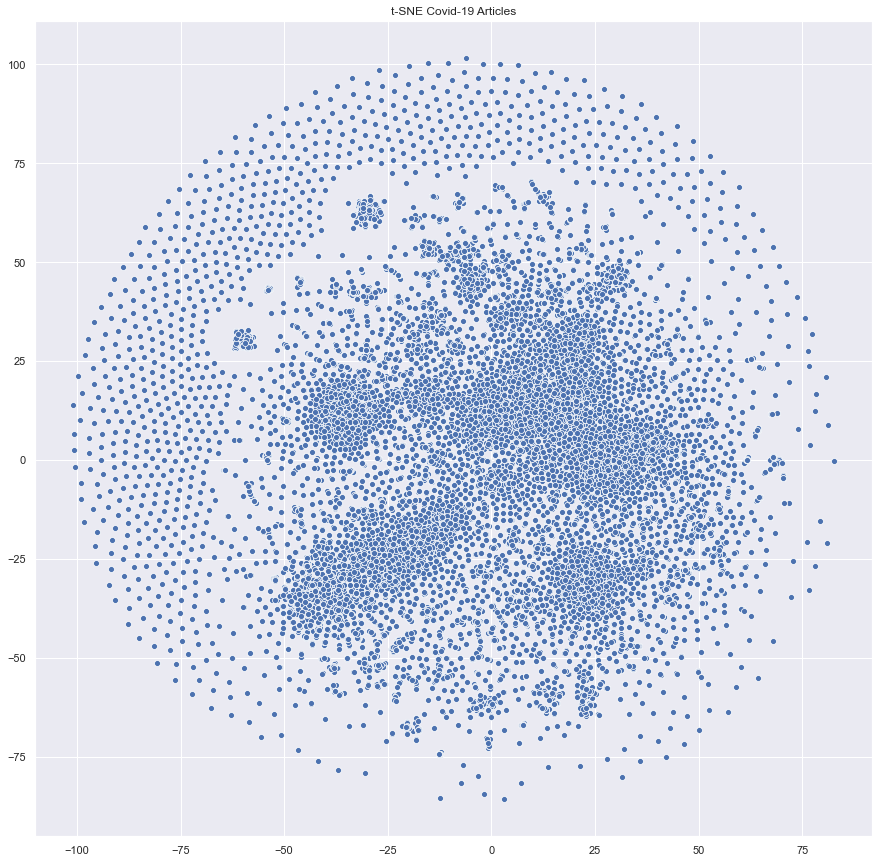

In [30]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)

plt.title("t-SNE Covid-19 Articles")
# plt.savefig("plots/t-sne_covid19.png")
plt.show()

## PCA
Using plain text and Tf-idf

In [43]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 3)
pca_result = pca.fit_transform(X.toarray())

2D Plot

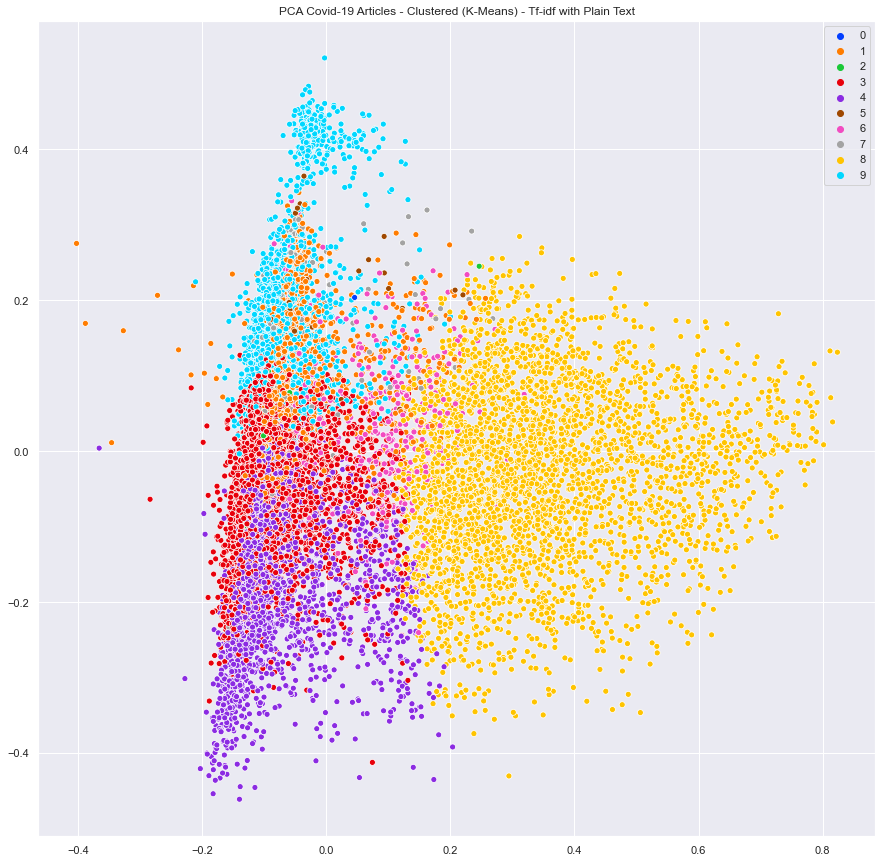

In [44]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", len(set(y)))

# plot
sns.scatterplot(pca_result[:,0], pca_result[:,1], hue=y, legend='full', palette=palette)
plt.title("PCA Covid-19 Articles - Clustered (K-Means) - Tf-idf with Plain Text")
# plt.savefig("plots/pca_covid19_label_TFID.png")
plt.show()

3D Plot

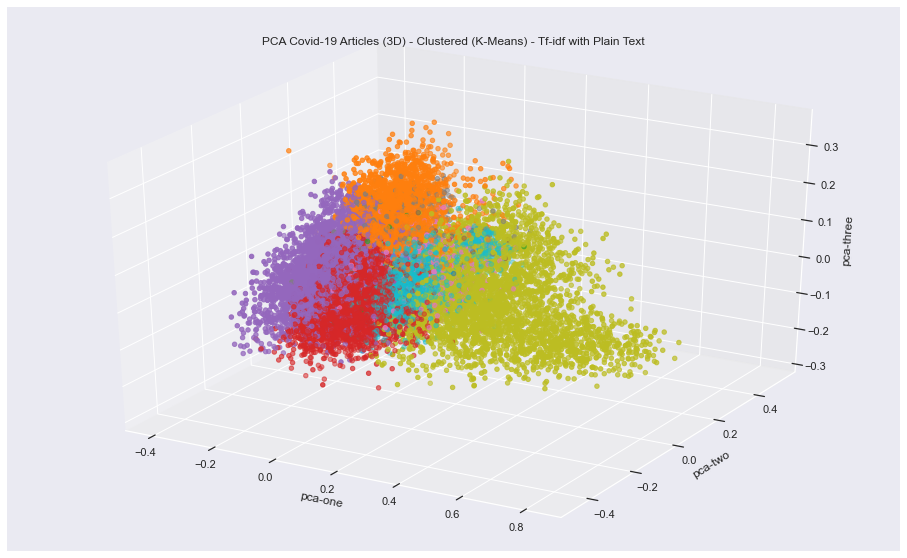

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=pca_result[:,0], 
    ys=pca_result[:,1], 
    zs=pca_result[:,2], 
    c=y, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.title("PCA Covid-19 Articles (3D) - Clustered (K-Means) - Tf-idf with Plain Text")
# plt.savefig("plots/pca_covid19_label_TFID_3d.png")
plt.show()

# Labeling

## KMeans

In [36]:
from sklearn.cluster import KMeans

k = 10
kmeans = KMeans(n_clusters=k, n_jobs=4, verbose=10)
y_pred = kmeans.fit_predict(X_train)

Training set

In [37]:
y_train = y_pred

Test set

In [38]:
y_test = kmeans.predict(X_test)

Plot

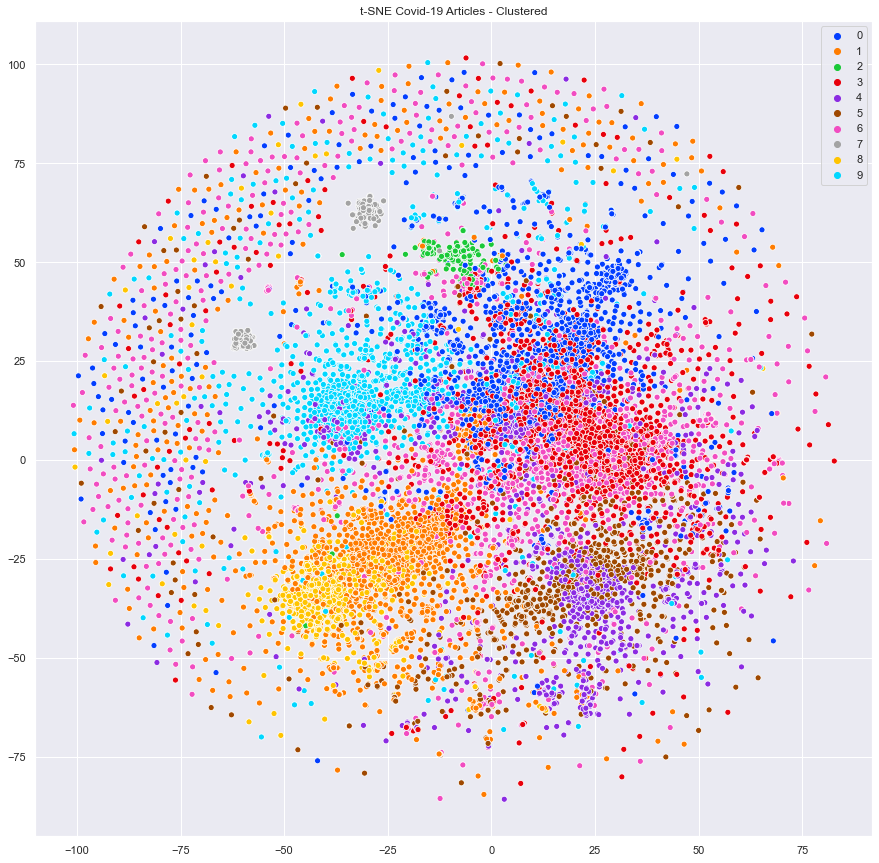

In [39]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", len(set(y_pred)))

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title("t-SNE Covid-19 Articles - Clustered")
plt.savefig("plots/t-sne_covid19_label.png", dpi=300)
plt.show()

## MiniBatchKMeans

In [40]:
from sklearn.cluster import MiniBatchKMeans

k = 10
kmeans = MiniBatchKMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)

In [42]:
y = y_pred

# Classify with RandomForest

Function to print out the classification model report

In [46]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

def class_report(model_name, test, pred):
    print(model_name, ":\n")
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, average='micro')) * 100), "%")
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, average='micro')) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='micro')) * 100), "%")
    

In [47]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# random forest classifier instance
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=4)

# cross validation on the training set 
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=3, n_jobs=4)

# print out the mean of the cross validation scores
print("Accuracy: ", '{:,.3f}'.format(float(forest_scores.mean()) * 100), "%")

Accuracy:  74.124 %


In [48]:
from sklearn.model_selection import cross_val_predict

# Crossvalidate predict on training set
forest_train_pred = cross_val_predict(forest_clf, X_train, y_train, cv=3, n_jobs=4)

# print precision and recall scores
print("Precision: ", '{:,.3f}'.format(float(precision_score(y_train, forest_train_pred, average='macro')) * 100), "%")
print("   Recall: ", '{:,.3f}'.format(float(recall_score(y_train, forest_train_pred, average='macro')) * 100), "%")

Precision:  81.593 %
   Recall:  70.458 %


Train, predict, validate

In [49]:
forest_clf.fit(X_train, y_train)
forest_pred = forest_clf.predict(X_test)

class_report("Random Forest Classifier Report (Test Set)", y_test, forest_pred)

Random Forest Classifier Report (Test Set) :

Accuracy Score:  75.534 %
     Precision:  75.534 %
        Recall:  75.534 %
      F1 score:  75.534 %


# Vectorize with tf-idf

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features = 2**12)
X = vectorizer.fit_transform(df_covid['body_text'].values)
X.shape

(19188, 4096)

# Dimension reduction with TSNE

In [52]:
tsne = TSNE(verbose=1)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 19188 samples in 39.034s...
[t-SNE] Computed neighbors for 19188 samples in 2041.373s...
[t-SNE] Computed conditional probabilities for sample 1000 / 19188
[t-SNE] Computed conditional probabilities for sample 2000 / 19188
[t-SNE] Computed conditional probabilities for sample 3000 / 19188
[t-SNE] Computed conditional probabilities for sample 4000 / 19188
[t-SNE] Computed conditional probabilities for sample 5000 / 19188
[t-SNE] Computed conditional probabilities for sample 6000 / 19188
[t-SNE] Computed conditional probabilities for sample 7000 / 19188
[t-SNE] Computed conditional probabilities for sample 8000 / 19188
[t-SNE] Computed conditional probabilities for sample 9000 / 19188
[t-SNE] Computed conditional probabilities for sample 10000 / 19188
[t-SNE] Computed conditional probabilities for sample 11000 / 19188
[t-SNE] Computed conditional probabilities for sample 12000 / 19188
[t-SNE] Computed conditional probabilities for

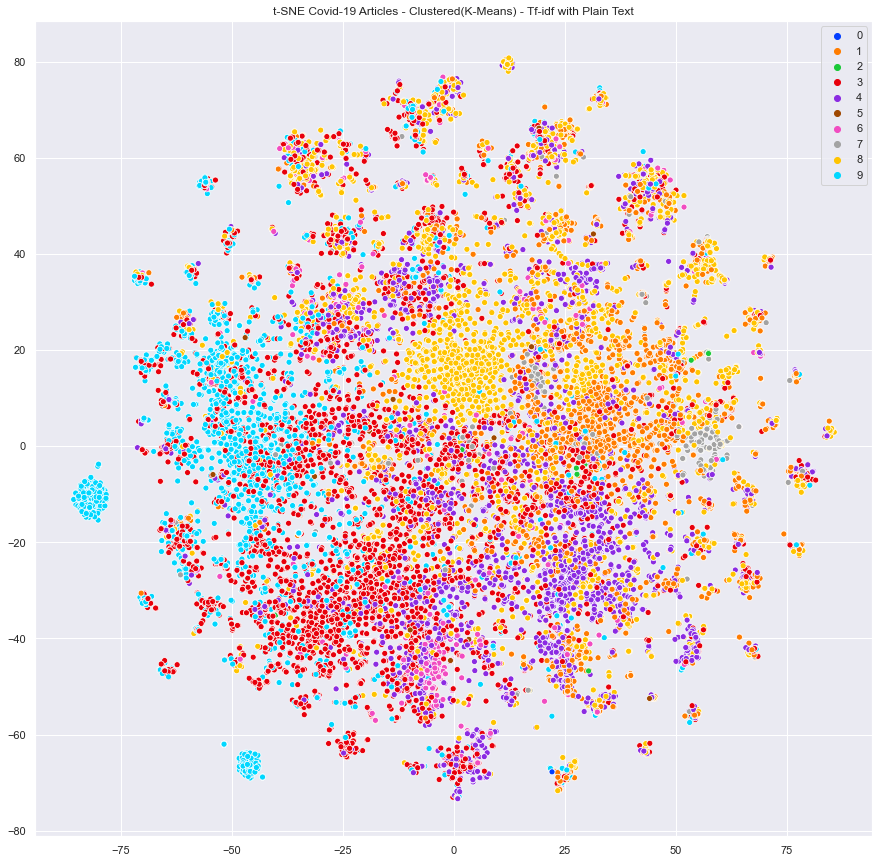

In [53]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", len(set(y)))

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette)
plt.title("t-SNE Covid-19 Articles - Clustered(K-Means) - Tf-idf with Plain Text")
# plt.savefig("plots/t-sne_covid19_label_TFID.png")
plt.show()

In [56]:
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, CustomJS
from bokeh.palettes import Category20
from bokeh.transform import linear_cmap
from bokeh.io import output_file, show
from bokeh.transform import transform
from bokeh.io import output_notebook
from bokeh.plotting import figure
from bokeh.layouts import column
from bokeh.models import RadioButtonGroup
from bokeh.models import TextInput
from bokeh.layouts import gridplot
from bokeh.models import Div
from bokeh.models import Paragraph
from bokeh.layouts import column, widgetbox

output_notebook()
y_labels = y_pred

# data sources
source = ColumnDataSource(data=dict(
    x= X_embedded[:,0], 
    y= X_embedded[:,1],
    x_backup = X_embedded[:,0],
    y_backup = X_embedded[:,1],
    desc= y_labels, 
    titles= df_covid['title'],
    authors = df_covid['authors'],
    journal = df_covid['journal'],
    abstract = df_covid['abstract_summary'],
    labels = ["C-" + str(x) for x in y_labels]
    ))

# hover over information
hover = HoverTool(tooltips=[
    ("Title", "@titles{safe}"),
    ("Author(s)", "@authors"),
    ("Journal", "@journal"),
    ("Abstract", "@abstract{safe}"),
],
                 point_policy="follow_mouse")

# map colors
mapper = linear_cmap(field_name='desc', 
                     palette=Category20[20],
                     low=min(y_labels) ,high=max(y_labels))

# prepare the figure
p = figure(plot_width=800, plot_height=800, 
           tools=[hover, 'pan', 'wheel_zoom', 'box_zoom', 'reset'], 
           title="t-SNE Covid-19 Articles, Clustered(K-Means), Tf-idf with Plain Text", 
           toolbar_location="right")

# plot
p.scatter('x', 'y', size=5, 
          source=source,
          fill_color=mapper,
          line_alpha=0.3,
          line_color="black",
          legend = 'labels')

# add callback to control 
callback = CustomJS(args=dict(p=p, source=source), code="""
            
            var radio_value = cb_obj.active;
            var data = source.data; 
            
            x = data['x'];
            y = data['y'];
            
            x_backup = data['x_backup'];
            y_backup = data['y_backup'];
            
            labels = data['desc'];
            
            if (radio_value == '20') {
                for (i = 0; i < x.length; i++) {
                    x[i] = x_backup[i];
                    y[i] = y_backup[i];
                }
            }
            else {
                for (i = 0; i < x.length; i++) {
                    if(labels[i] == radio_value) {
                        x[i] = x_backup[i];
                        y[i] = y_backup[i];
                    } else {
                        x[i] = undefined;
                        y[i] = undefined;
                    }
                }
            }


        source.change.emit();
        """)

# callback for searchbar
keyword_callback = CustomJS(args=dict(p=p, source=source), code="""
            
            var text_value = cb_obj.value;
            var data = source.data; 
            
            x = data['x'];
            y = data['y'];
            
            x_backup = data['x_backup'];
            y_backup = data['y_backup'];
            
            abstract = data['abstract'];
            titles = data['titles'];
            authors = data['authors'];
            journal = data['journal'];

            for (i = 0; i < x.length; i++) {
                if(abstract[i].includes(text_value) || 
                   titles[i].includes(text_value) || 
                   authors[i].includes(text_value) || 
                   journal[i].includes(text_value)) {
                    x[i] = x_backup[i];
                    y[i] = y_backup[i];
                } else {
                    x[i] = undefined;
                    y[i] = undefined;
                }
            }
            


        source.change.emit();
        """)

# option
option = RadioButtonGroup(labels=["C-0", "C-1", "C-2",
                                  "C-3", "C-4", "C-5",
                                  "C-6", "C-7", "C-8",
                                  "C-9", "C-10", "C-11",
                                  "C-12", "C-13", "C-14",
                                  "C-15", "C-16", "C-17",
                                  "C-18", "C-19", "All"], 
                          active=20, callback=callback)

# search box
keyword = TextInput(title="Search:", callback=keyword_callback)

#header
header = Div(text="""<h1>COVID-19 Literature Cluster</h1>""")

# show
show(column(header, widgetbox(option, keyword),p))

Loading BokehJS ...

AttributeError: unexpected attribute 'callback' to RadioButtonGroup, similar attributes are js_event_callbacks